<a href="https://colab.research.google.com/github/principioincertidumbre/dataviz/blob/main/Tarea_3_MLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Profesor: Tomás Fontecilla</em><br>

</div>

# **Machine Learning Avanzado: Tarea N°3**
*17 de diciembre de 2024*

Integrantes:

- Julio Assmann
- Diego León
- Sofía Vits

## Introducción

# Objetivos

## Metodología

In [2]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.9 MB/s eta 0:00:00


In [9]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from keras import models, layers, optimizers, regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import random
import kagglehub
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as adfuller
import ruptures as rpt
# Establecer la semilla para Python
random.seed(42)

# Establecer la semilla para NumPy
np.random.seed(42)

# Establecer la semilla para TensorFlow
tf.random.set_seed(42)

## Modelos

### Autoencoder

#### Carga de datos

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving denoising-dirty-documents.zip to denoising-dirty-documents.zip


In [ ]:
!unzip denoising-dirty-documents.zip
!unzip train.zip
!unzip train_cleaned.zip
!unzip test.zip

Archive:  denoising-dirty-documents.zip
  inflating: sampleSubmission.csv.zip  
  inflating: test.zip                
  inflating: train.zip               
  inflating: train_cleaned.zip       
Archive:  train.zip
   creating: train/
  inflating: train/101.png           
  inflating: train/102.png           
  inflating: train/104.png           
  inflating: train/105.png           
 extracting: train/107.png           
 extracting: train/108.png           
 extracting: train/11.png            
  inflating: train/110.png           
 extracting: train/111.png           
  inflating: train/113.png           
  inflating: train/114.png           
 extracting: train/116.png           
  inflating: train/117.png           
 extracting: train/119.png           
 extracting: train/12.png            
 extracting: train/120.png           
  inflating: train/122.png           
 extracting: train/123.png           
  inflating: train/125.png           
  inflating: train/126.png           
  infl

In [ ]:
!ls

denoising-dirty-documents.zip  sampleSubmission.csv.zip  test.zip  train_cleaned      train.zip
sample_data		       test			 train	   train_cleaned.zip


In [ ]:
import cv2
import os
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))

    return img

X_train = []
y_train = []
X_test = []

for f in sorted(os.listdir('train/')):
    X_train.append(process_image('train/' + f))

for f in sorted(os.listdir('train_cleaned/')):
    y_train.append(process_image('train_cleaned/' + f))

for f in sorted(os.listdir('test/')):
    X_test.append(process_image('test/' + f))

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)

#### Exploración de datos

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (144, 420, 540, 1)
X_test shape: (72, 420, 540, 1)


Función para mostrar imágenes de ejemplo

In [ ]:
def plot_images_in_grid(images, titles, n_examples=10, n_rows=2, figsize=(15, 5)):
    """
    Generaliza la creación de una grilla para mostrar imágenes.

    Parameters:
    - images: Lista de imágenes a mostrar.
    - titles: Lista de títulos para cada imagen.
    - n_examples: Número máximo de ejemplos a mostrar.
    - n_rows: Número de filas en la grilla.
    - figsize: Tamaño de la figura (tupla).
    """
    n_cols = (n_examples + n_rows - 1) // n_rows
    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Convertir ax a una lista, incluso si es un único objeto
    if n_rows == 1 or n_cols == 1:
        ax = np.array(ax).flatten()
    else:
        ax = ax.flatten()

    for idx in range(len(ax)):
        if idx < n_examples and idx < len(images):
            ax[idx].imshow(images[idx])
            ax[idx].set_title(titles[idx])
            ax[idx].axis('off')
        else:
            ax[idx].axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()


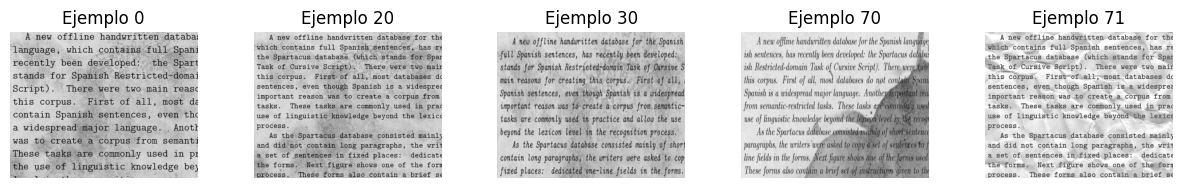

In [ ]:
example_idx = [0, 20, 30, 70, 71]
filtered_images = [X_test[img_idx]/255 for img_idx in example_idx]
filtered_titles = [f'Ejemplo {img_idx}' for img_idx in example_idx]

plot_images_in_grid(filtered_images, filtered_titles, n_examples=len(filtered_images), n_rows=1)

#### Modelo autoencoder y entrenamiento

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42)

In [ ]:
class ConvAutoEncoder(Model):
    def __init__(self, input_shape):
        super().__init__()

        # Encoder
        self.encoder = Sequential([
            Input(shape=input_shape),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same'),
            Dropout(0.5)
        ])

        # Decoder
        self.decoder = Sequential([
            Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),
            Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - loss: 0.0691 - mse: 0.1983 - val_loss: 0.0549 - val_mse: 0.1555
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 662ms/step - loss: 0.0479 - mse: 0.1365 - val_loss: 0.0360 - val_mse: 0.0936
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 670ms/step - loss: 0.0312 - mse: 0.0797 - val_loss: 0.0309 - val_mse: 0.0698
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 681ms/step - loss: 0.0282 - mse: 0.0644 - val_loss: 0.0317 - val_mse: 0.0704
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 697ms/step - loss: 0.0285 - mse: 0.0645 - val_loss: 0.0307 - val_mse: 0.0683
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 712ms/step - loss: 0.0275 - mse: 0.0627 - val_loss: 0.0296 - val_mse: 0.0682
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 720ms/step - loss: 0.0268 - mse: 0.0633 - val_loss: 0.0288 - val_mse: 0.0658
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 709ms/step - loss: 0.0260 - mse: 0.0602 - val_loss: 0.0278 - val_mse: 0.0625
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 709ms/step - loss: 0.0250 - mse

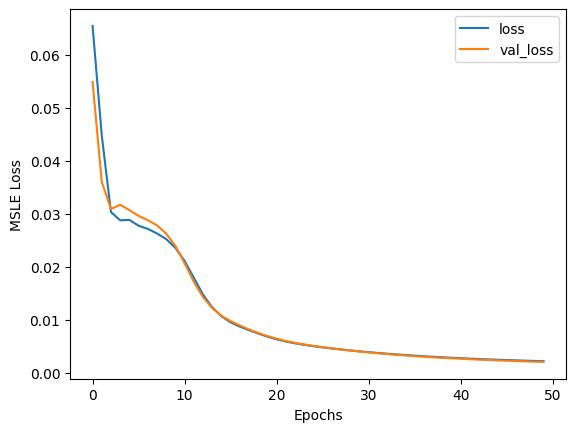

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

image_size=(420, 540)
model = ConvAutoEncoder(input_shape = (image_size[0], image_size[1], 1))
# configurations of model
lr = 1e-4
model.compile(loss='msle', metrics =['mse'], optimizer = optimizers.Adam(learning_rate=lr))
callback = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

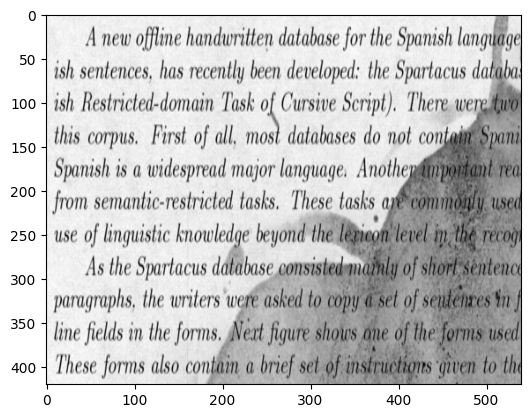

In [ ]:
plt.imshow(X_test[0, :, :, :], cmap = 'gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


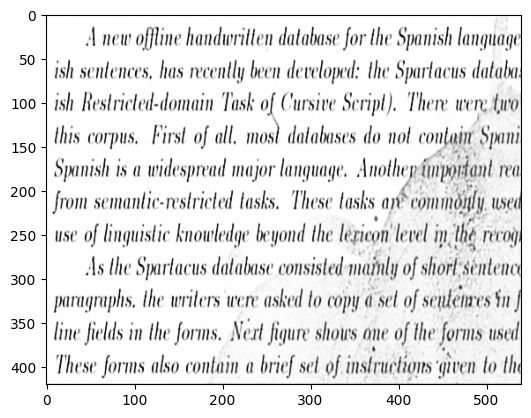

In [ ]:
y_pred_ae = model.predict(X_test[0:5, :, :, :])
plt.imshow(y_pred_ae[0, :, :, :], cmap='gray')

### LSTM

### Análisis producción de leche entre los años 1962 y 1975

In [5]:
df_leche = pd.read_csv('monthly_milk_production.csv')

In [6]:
df_leche.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [7]:
df_leche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [8]:
df_leche.shape

(168, 2)

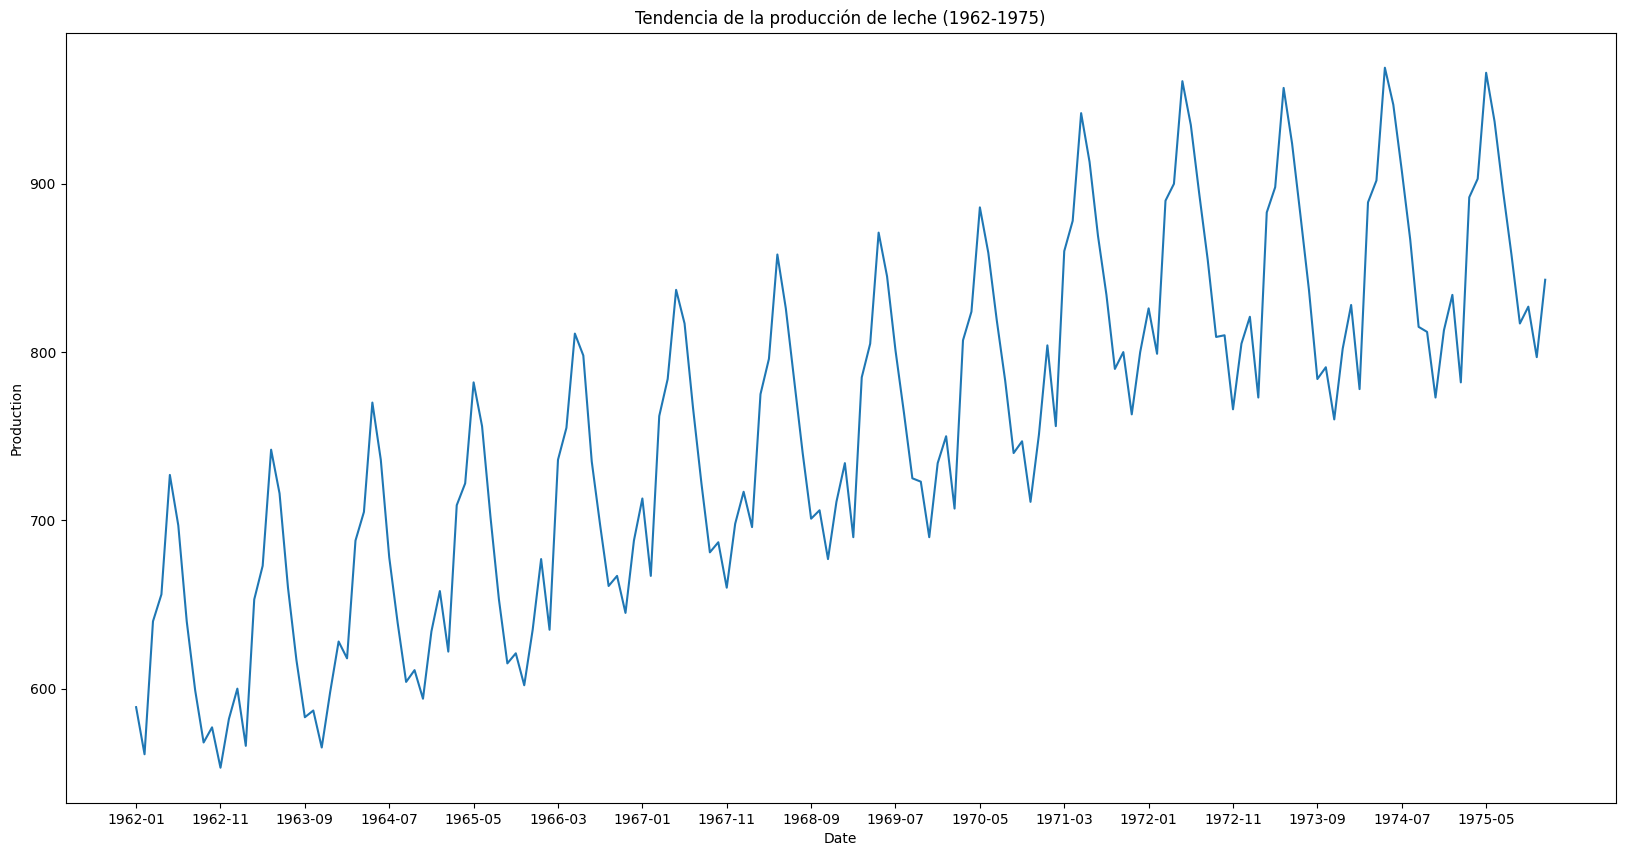

In [23]:
# Análisis temporal: Cambios de "Production" a lo largo del tiempo
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=df_leche, x='Date', y='Production')
plt.title('Tendencia de la producción de leche (1962-1975)')
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

## Análisis de resultados

## Conclusiones